In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Load your time series dataset
data = pd.read_csv("C:/Users/raulp/OneDrive/Documenten/KU Leuven/Master HIRB/Thesis/sens_RUL_generated_just.csv")

# Columns to convert to numeric
numeric_columns = ["RMSVibration.mean", "Temperature.mean", "SpeedPeak.mean", "Kurtosis.mean",
                   "RMSAcceleration.mean", "Skewness.mean", "MaximumAbsoluteVibration.mean"]

# Use "." as decimal seperator instead of ","
for col in numeric_columns:
    data[col] = data[col].str.replace(',', '.')

# Convert selected columns to numeric
# Parameter errors="coerce" converts problematic values into NaN
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors="coerce")

# FEATURE ENGINEERING
# Feature 1: Lags and deltas of the attributes
#for i in range(1, 10):
#    for col in numeric_columns:
#        data[f'{col}_Lag{i}'] = data[col].shift(i)
#        data[f'{col}_Lag{i}'][i - 1] = data[col][i - 1]
#        data[f'{col}_Delta{i}'] = data[col] - data[f'{col}_Lag{i}']

# Feature 2: Rolling statistics 
window_size = 10
for column in numeric_columns:
    data[f'{column}_RollingMean'] = data[column].rolling(window=window_size, min_periods=1).mean()
    data[f'{column}_RollingStd'] = data[column].rolling(window=window_size, min_periods=1).std()
    data[f'{column}_RollingMin'] = data[column].rolling(window=window_size, min_periods=1).min()
    data[f'{column}_RollingMax'] = data[column].rolling(window=window_size, min_periods=1).max()
    data[f'{column}_RollingStd'][0] = 0
data = data.drop(['SpeedPeak.mean_RollingMin', 'RMSVibration.mean_RollingMin', 'RMSAcceleration.mean_RollingMin'], axis=1)

# Drop columns that are not needed in the analysis
# Parameter axis=1 makes sure that we drop columns
data = data.drop(['Unnamed: 0', 'Time', 'TrueRUL', 'ReadableDate'], axis=1)

# Drop all initial sensor features, hold no importance after other features have been derived
data = data.drop(numeric_columns, axis=1)

# Drop rows with NaN values, if there are any
nan_rows = data[data.isna().any(axis=1)]
data = data.dropna()

# Assume the 'FloatRUL' column is your target variable, and other columns are features
X = data.drop(['FloatRUL'], axis=1)
y = data['FloatRUL']

# Use the oldest data for training, then the next portion for validation, and the newest for testing
# Split 70-15-15
train_size = int(0.70 * len(data))
val_size = int(0.15 * len(data))
train_data, val_data, test_data = data[:train_size], data[train_size:train_size+val_size], data[train_size+val_size:]

# Split the data into features (X) and target variable (y)
X_train, y_train = train_data.drop('FloatRUL', axis=1), train_data['FloatRUL']
X_val, y_val = val_data.drop('FloatRUL', axis=1), val_data['FloatRUL']
X_test, y_test = test_data.drop('FloatRUL', axis=1), test_data['FloatRUL']

<ipython-input-1-f38bb4e54ff3>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{column}_RollingStd'][0] = 0


In [2]:
from math import sqrt
# Build the RF model
model = RandomForestRegressor(n_estimators=400, min_samples_split=7, max_features='sqrt', random_state=42, n_jobs=-1)

model.fit(X_train, y_train)

# Make predictions on the validation set
val_predictions = model.predict(X_val)
val_mse = mean_squared_error(y_val, val_predictions)
val_rmse = sqrt(val_mse)
print(f'Validation RMSE: {val_rmse}')

# Make predictions on the test set
test_predictions = model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = sqrt(test_mse)
print(f'Test RMSE: {test_rmse}')


Validation RMSE: 20.1979036328545
Test RMSE: 23.949726004743432


In [3]:
# Check feature importances
feature_importances = model.feature_importances_
feature_names = X_train.columns

imp = []
for feature, importance in zip(feature_names, feature_importances):
    imp.append([feature, importance])

def keyFunc(mtx):
    return mtx[1]

imp.sort(reverse=True, key=keyFunc)
for elem in imp:
    print(elem)

['Temperature.mean_RollingMin', 0.13926953743461426]
['Temperature.mean_RollingMax', 0.08983500051175428]
['Temperature.mean_RollingStd', 0.0582807340743612]
['Temperature.mean_RollingMean', 0.057594407772155555]
['RMSVibration.mean_RollingMax', 0.05743547881012109]
['RMSAcceleration.mean_RollingMax', 0.05639047983569497]
['MaximumAbsoluteVibration.mean_RollingStd', 0.05223157667875908]
['SpeedPeak.mean_RollingMax', 0.04993521321665059]
['MaximumAbsoluteVibration.mean_RollingMax', 0.04879569668688313]
['SpeedPeak.mean_RollingStd', 0.0481295717571082]
['SpeedPeak.mean_RollingMean', 0.043201253287659704]
['RMSAcceleration.mean_RollingStd', 0.04153202957121674]
['RMSVibration.mean_RollingStd', 0.041413697696339014]
['Kurtosis.mean_RollingStd', 0.04120055429347782]
['RMSVibration.mean_RollingMean', 0.03772601998463742]
['RMSAcceleration.mean_RollingMean', 0.03766615321607777]
['MaximumAbsoluteVibration.mean_RollingMean', 0.03625868729332135]
['Kurtosis.mean_RollingMean', 0.0355759582752309

In [ ]:
from sklearn.model_selection import ParameterGrid

estimators = []
for i in range(50, 401, 10):
    estimators.append(i)
    
samplessplit = []
for i in range(2, 13):
    samplessplit.append(i)

param_grid = {"n_estimators": estimators,
              "max_features": ["sqrt", "log2"],
              "min_samples_split": samplessplit,
              "random_state": [42],
              "n_jobs": [-1]}

param_grid = ParameterGrid(param_grid)
best_score = float('-inf')
best_params = None
rf = RandomForestRegressor()
for i, params in enumerate(param_grid, start=1):
    rf.set_params(**params)
    rf.fit(X_train, y_train)
    score = rf.score(X_val, y_val)
    print(f'Iteration {i}/{len(param_grid)} - Parameters: {params}, Score: {score}')
    if score > best_score:
        best_score = score
        best_params = params
best_rf_model = RandomForestRegressor()
best_rf_model.set_params(**best_params)
best_rf_model.fit(X_train, y_train)

In [ ]:
print("R2 train set:", model.score(X_train, y_train))
print("R2 validation set:", model.score(X_val, y_val))
print("R2 test set:", model.score(X_test, y_test))

print("\nBest model according to Grid Search:")
print("R2 train set:", best_rf_model.score(X_train, y_train))
print("R2 validation set:", best_rf_model.score(X_val, y_val))
print("R2 test set:", best_rf_model.score(X_test, y_test))

In [24]:
val_predictions = best_rf_model.predict(X_val)
val_mse = mean_squared_error(y_val, val_predictions)
val_rmse = sqrt(val_mse)
print(f'Validation RMSE: {val_rmse}')

Validation RMSE: 20.1979036328545


In [13]:
from math import sqrt


def test_architecture(window_size, lags):
    # Load your time series dataset
    data = pd.read_csv("C:/Users/raulp/OneDrive/Documenten/KU Leuven/Master HIRB/Thesis/sens_RUL_generated_just.csv")

    # Columns to convert to numeric
    numeric_columns = ["RMSVibration.mean", "Temperature.mean", "SpeedPeak.mean", "Kurtosis.mean",
                       "RMSAcceleration.mean", "Skewness.mean", "MaximumAbsoluteVibration.mean"]

    # Use "." as decimal seperator instead of ","
    for col in numeric_columns:
        data[col] = data[col].str.replace(',', '.')

    # Convert selected columns to numeric
    # Parameter errors="coerce" converts problematic values into NaN
    data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors="coerce")

    # FEATURE ENGINEERING
    # Feature 1: Lags and deltas of the attributes
    for i in range(1, lags + 1):
        for col in numeric_columns:
            data[f'{col}_Lag{i}'] = data[col].shift(i)
            data[f'{col}_Lag{i}'][i - 1] = data[col][i - 1]
            data[f'{col}_Delta{i}'] = data[col] - data[f'{col}_Lag{i}']

    # Feature 2: Rolling statistics 
    for column in numeric_columns:
        data[f'{column}_RollingMean'] = data[column].rolling(window=window_size, min_periods=1).mean()
        data[f'{column}_RollingStd'] = data[column].rolling(window=window_size, min_periods=1).std()
        data[f'{column}_RollingMin'] = data[column].rolling(window=window_size, min_periods=1).min()
        data[f'{column}_RollingMax'] = data[column].rolling(window=window_size, min_periods=1).max()
        data[f'{column}_RollingStd'][0] = 0

    # Drop columns that are not needed in the analysis
    # Parameter axis=1 makes sure that we drop columns
    data = data.drop(['Unnamed: 0', 'Time', 'TrueRUL', 'ReadableDate'], axis=1)

    # Drop all initial sensor features, hold no importance after other features have been derived
    #data = data.drop(numeric_columns, axis=1)

    # Drop rows with NaN values, if there are any
    #nan_rows = data[data.isna().any(axis=1)]
    data = data.dropna()

    # Assume the 'FloatRUL' column is your target variable, and other columns are features
    X = data.drop(['FloatRUL'], axis=1)
    y = data['FloatRUL']

    # Use the oldest data for training, then the next portion for validation, and the newest for testing
    # Split 70-15-15
    train_size = int(0.70 * len(data))
    val_size = int(0.15 * len(data))
    train_data, val_data, test_data = data[:train_size], data[train_size:train_size+val_size], data[train_size+val_size:]

    # Split the data into features (X) and target variable (y)
    X_train, y_train = train_data.drop('FloatRUL', axis=1), train_data['FloatRUL']
    X_val, y_val = val_data.drop('FloatRUL', axis=1), val_data['FloatRUL']
    X_test, y_test = test_data.drop('FloatRUL', axis=1), test_data['FloatRUL']
    
    test_model = RandomForestRegressor(max_features='sqrt', min_samples_split=8, n_estimators=370, n_jobs=-1, random_state=42)
    test_model.fit(X_train, y_train)
    
    # Make predictions on the validation set
    val_predictions = test_model.predict(X_val)
    val_mse = mean_squared_error(y_val, val_predictions)
    val_rmse = sqrt(val_mse)
    
    return val_rmse, test_model.score(X_val, y_val)

In [ ]:
import warnings

# Suppress SettingWithCopyWarning
warnings.filterwarnings('ignore', category=pd.core.common.SettingWithCopyWarning)

bestrmse = 99
for i in range(2, 61):
    for j in range(1, 11):
        rmse, score = test_architecture(i, j)
        print(f'window size {i} & {j} lags: RMSE = {rmse}, R2 = {score}')
        if rmse < bestrmse:
            bestrmse = rmse
            bestscore = score
            bestwindow = i
            bestlags = j

print(f'Best results: window size {bestwindow} & {bestlags} lags: RMSE = {bestrmse}, R2 = {bestscore}')

In [5]:
from math import sqrt

# Combine train and validation sets (resulting in a 85-15 split) in order to report final results
train_data_final, test_data_final = data[:train_size+val_size], data[train_size+val_size:]

# Split the data into features (X) and target variable (y)
X_train_final, y_train_final = train_data_final.drop('FloatRUL', axis=1), train_data_final['FloatRUL']
X_test_final, y_test_final = test_data_final.drop('FloatRUL', axis=1), test_data_final['FloatRUL']

# Train the model
best_rf_model.fit(X_train_final, y_train_final)

# Evaluate on the test set
test_predictions = best_rf_model.predict(X_test_final)
test_rmse = sqrt(mean_squared_error(y_test_final, test_predictions))
print(f'Test RMSE: {test_rmse}')
print("R2 test set:", best_rf_model.score(X_test_final, y_test_final))

Test RMSE: 18.75965176725428
R2 test set: -15.35500404015109


In [ ]:
y_test_final_reset = y_test_final.reset_index(drop=True)

# Convert the arrays to pandas Series
predictions_series = pd.Series(test_predictions, name="Predictions")
true_values_series = pd.Series(y_test_final_reset, name="True values")

# Concatenate the Series into a single DataFrame
df = pd.concat([predictions_series, true_values_series], axis=1)


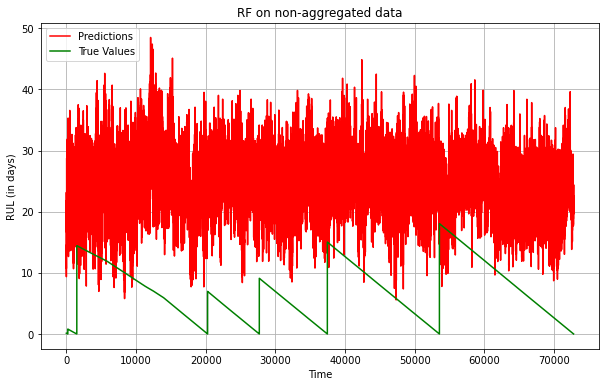

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Uittellen zodat we een voorspelling per uur krijgen, in lijn met Ward zijn deel
shortened_predictions = [test_predictions[i] for i in range(0, len(test_predictions), 500)]
shortened_y_test = [y_test_final_reset[i] for i in range(0, len(y_test_final_reset), 500)]

plt.figure(figsize=(10, 6))
plt.plot(test_predictions, label='Predictions', color='red')
plt.plot(y_test_final_reset, label='True Values', color='green')
plt.xlabel('Time')
plt.ylabel('RUL (in days)')
plt.title('RF on non-aggregated data')
plt.legend(loc='upper left')
plt.grid(True)

plt.savefig("Plot non aggregated data.pdf")

plt.show()
